## PROJECT 23: Toxic Comment Classification

> ### TASK: Identify and classify toxic online comments

### Project goals and objectives

#### Project goal

- Studying **transfer learning for NLP**

#### Project objectives

1. Explore and prepare data 
2. Use Tensorflow HUB and Universal Sentence Encoder 

#### IMPORT LIBRARIE

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from tqdm import tqdm
tqdm.pandas()

import re
import unidecode

from collections import Counter

import nltk
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D, Dropout, Dense,GlobalAveragePooling1D, Input, Embedding, MaxPool1D, Flatten
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow_hub as hub


import pydot
import graphviz

#### Load data

In [2]:
# Path to data
train_data_path = "data/train.csv"
test_data_path = "data/test.csv"

In [3]:
# Create dataframe
train_df = pd.read_csv(train_data_path)
test_df = pd.read_csv(test_data_path)

In [4]:
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [6]:
print(f"Total training samples: {len(train_df)}, traing shape: {train_df.shape}")
print(f"Total test samples: {len(test_df)}, test shape: {test_df.shape}")
print(f"Total samples: {len(train_df) + len(test_df)}")

Total training samples: 159571, traing shape: (159571, 8)
Total test samples: 153164, test shape: (153164, 2)
Total samples: 312735


In [7]:
# Check for null values
print(f"Train data: \n{train_df.isnull().sum()}")
print(f"\nTest data: \n{test_df.isnull().sum()}")

Train data: 
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

Test data: 
id              0
comment_text    0
dtype: int64


### DATA PREPROCESSING

In [8]:
# Separate x and y component from training set

x_train = train_df["comment_text"]

y_train = train_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

x_test = test_df["comment_text"]

### EVALUATION AND VISUALIZATION OF MODEL PARAMETERS

In [9]:
def learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(20, 8))
    plt.grid(True)
    plt.title('Learning curves')
    plt.gca().set_ylim(0, 1)
    plt.show()


def evaluation_model(history):
    fig, (axL, axR) = plt.subplots(ncols=2, figsize=(20, 8))
    axL.plot(history.history['loss'], label="Training loss")
    axL.plot(history.history['val_loss'], label="Validation loss")
    axL.set_title('Training and Validation loss')
    axL.set_xlabel('Epochs')
    axL.set_ylabel('Loss')
    axL.legend(loc='upper right')

    axR.plot(history.history['accuracy'], label="Training accuracy")
    axR.plot(history.history['val_accuracy'], label="Validation accuracy")
    axR.set_title('Training and Validation accuracy')
    axR.set_xlabel('Epoch')
    axR.set_ylabel('Accuracy')
    axR.legend(loc='upper right')

    plt.show()


def calculate_results(y_true, y_pred):
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted",
                                                                                 labels=np.unique(y_pred))
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

## TensorFlow Hub Pretrained Sentence Encode

In [10]:
# Base pretrained layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], 
                                        dtype=tf.string, 
                                        trainable=False, 
                                        name="USE")

2021-10-27 20:54:08.015591: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 20:54:08.024866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 20:54:08.025726: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-27 20:54:08.027445: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [11]:
# Model 
model_USE = Sequential([sentence_encoder_layer,
                    Dense(512, activation="relu"),
                    Dropout(0.5),
                    Dense(256, activation="relu"),
                    Dropout(0.4),
                    Dense(128, activation="relu"),
                    Dropout(0.3),
                    Dense(64, activation="relu"),
                    Dropout(0.2),
                    Dense(6, activation="sigmoid")], 
                    name="USE_model")

In [12]:
# Compile model
model_USE.compile(loss="binary_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])

Model: "USE_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0 

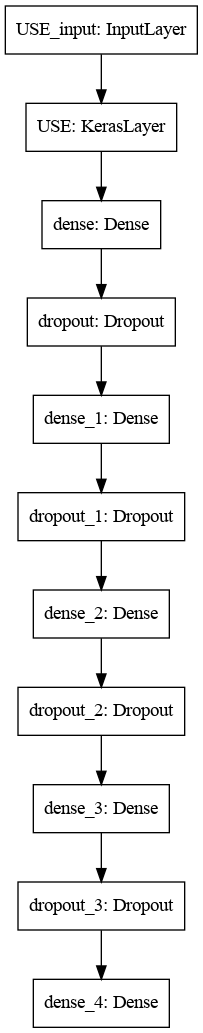

In [13]:
model_USE.summary()
tf.keras.utils.plot_model(model_USE, to_file='USE_model.png')

In [14]:
model_USE_history = model_USE.fit(x_train,
                                  y_train,
                                  batch_size=64,
                                  validation_split=0.15,
                                  epochs=5)

Epoch 1/5
2120/2120 [==============================] - 124s 57ms/step - loss: 0.0732 - accuracy: 0.9022 - val_loss: 0.0595 - val_accuracy: 0.9944
Epoch 2/5
2120/2120 [==============================] - 121s 57ms/step - loss: 0.0622 - accuracy: 0.9890 - val_loss: 0.0580 - val_accuracy: 0.9944
Epoch 3/5
2120/2120 [==============================] - 121s 57ms/step - loss: 0.0593 - accuracy: 0.9869 - val_loss: 0.0582 - val_accuracy: 0.9944
Epoch 4/5
2120/2120 [==============================] - 121s 57ms/step - loss: 0.0573 - accuracy: 0.9855 - val_loss: 0.0567 - val_accuracy: 0.9944
Epoch 5/5
2120/2120 [==============================] - 121s 57ms/step - loss: 0.0547 - accuracy: 0.9906 - val_loss: 0.0565 - val_accuracy: 0.9944


### EVALUATION RESULT

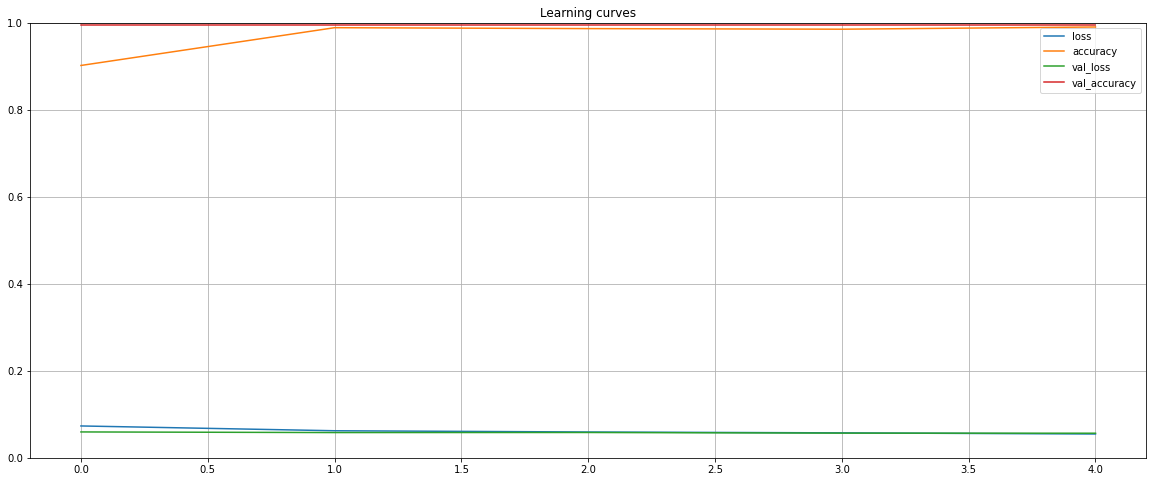

In [15]:
# Learning curves
learning_curves(model_USE_history)

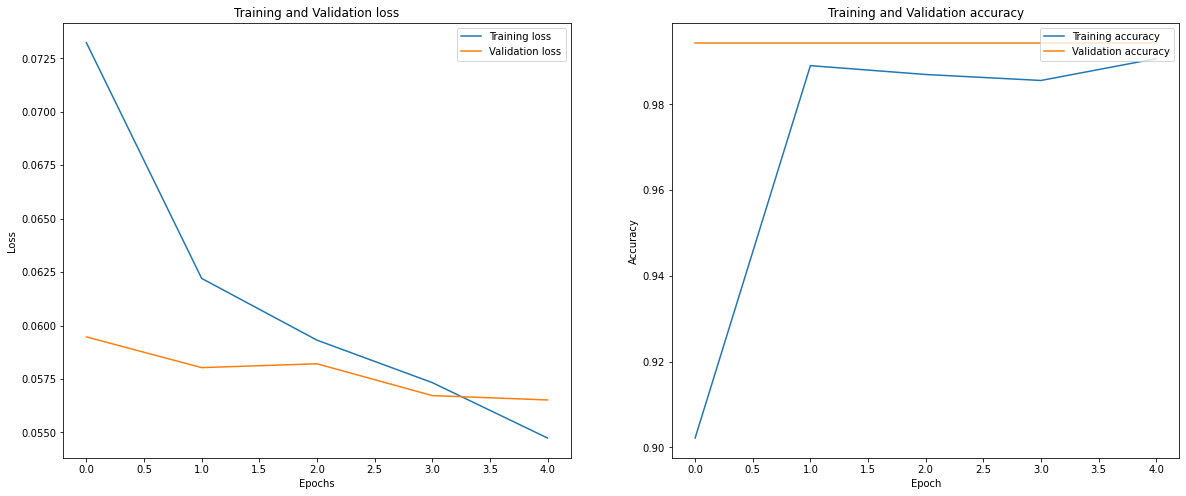

In [16]:
# Evaluation model
evaluation_model(model_USE_history)

In [17]:
# Check the results
model_USE.evaluate(x_test)

4787/4787 [==============================] - 12s 3ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00


[0.0, 0.0]

In [18]:
# Predictions
model_USE_pred = model_USE.predict(x_test, batch_size=32)
model_USE_pred

array([[9.8702919e-01, 1.7823100e-01, 8.0481535e-01, 2.7402123e-02,
        7.9955196e-01, 3.1412289e-01],
       [2.0260967e-03, 1.7307850e-10, 7.9227822e-05, 7.3776353e-11,
        1.1484265e-05, 4.4629109e-09],
       [8.8498844e-03, 5.1318263e-08, 5.2463938e-04, 5.9655818e-08,
        1.1711048e-04, 9.2505945e-07],
       ...,
       [1.5055288e-02, 2.4659107e-07, 1.5267020e-03, 3.0516827e-07,
        4.1205308e-04, 2.4816586e-06],
       [4.1031837e-03, 1.3747073e-08, 9.6077492e-05, 5.5159461e-08,
        2.0999611e-05, 1.1263839e-05],
       [6.7792636e-01, 7.7071483e-03, 2.1255668e-01, 1.9684939e-03,
        3.5061023e-01, 2.0054923e-02]], dtype=float32)